## Warning!
This notebook is only for experimental purposes while learning, working with data of Ashrae Kaggle Competition. It won't be part of the final project, and will be removed from the repository.

### Training data sets structure

**train.csv**
* `building_id` - Foreign key for the building metadata.
* `meter` - The meter id code. Read as `{0: electricity, 1: chilledwater, 2: steam, 3: hotwater}`. Not every building has all meter types.
* `timestamp`  - When the measurement was taken
* `meter_reading` - The target variable. Energy consumption in kWh (or equivalent). Note that this is real data with measurement error, which we expect will impose a baseline level of modeling error.

**building_meta.csv**
* `site_id` - Foreign key for the weather files.
* `building_id` - Foreign key for training.csv
* `primary_use` - Indicator of the primary category of activities for the building based on EnergyStar property type definitions
* `square_feet` - Gross floor area of the building
* `year_built` - Year building was opened
* `floor_count` - Number of floors of the building

**weather_[train/test].csv**

Weather data from a meteorological station as close as possible to the site.

* `site_id`
* `air_temperature` - Degrees Celsius
* `cloud_coverage` - Portion of the sky covered in clouds, in oktas
* `dew_temperature` - Degrees Celsius
* `precip_depth_1_hr` - Millimeters
* `sea_level_pressure` - Millibar/hectopascals
* `wind_direction` - Compass direction (0-360)
* `wind_speed` - Meters per second

##  Loading data

In [2]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import datetime as dt
import gc
from src.functions import utils as utl
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno

In [2]:
# Importing data
train = utl.import_data('../data/raw/train.csv') 


Memory usage of dataframe is 616.95 MB
Memory usage after optimization is: 173.90 MB
Decreased by 71.8%


In [3]:
building_meta = utl.import_data('../data/raw/building_metadata.csv')

Memory usage of dataframe is 0.07 MB
Memory usage after optimization is: 0.02 MB
Decreased by 73.8%


In [3]:
weather_train = utl.import_data('../data/raw/weather_train.csv')

Memory usage of dataframe is 9.60 MB
Memory usage after optimization is: 2.65 MB
Decreased by 72.4%


## Wrangling


#### Data set `building_meta` 

In [5]:
building_meta.shape

(1449, 6)

In [6]:
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008.0,NaN
1,0,1,Education,2720,2004.0,NaN
2,0,2,Education,5376,1991.0,NaN
3,0,3,Education,23685,2002.0,NaN
4,0,4,Education,116607,1975.0,NaN


In [7]:
building_meta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1449 entries, 0 to 1448
Data columns (total 6 columns):
site_id        1449 non-null int8
building_id    1449 non-null int16
primary_use    1449 non-null category
square_feet    1449 non-null int32
year_built     675 non-null float16
floor_count    355 non-null float16
dtypes: category(1), float16(2), int16(1), int32(1), int8(1)
memory usage: 17.8 KB


El campo `year_built` es de tipo `float`. Vamos a convertirlo a `str`, quitándole además el decimal

In [5]:
building_meta['year_built'] = building_meta['year_built'].astype(str, errors='ignore')

In [6]:
f = lambda x: x.replace('.0','')
building_meta['year_built'] = building_meta['year_built'].apply(f)

In [10]:
building_meta.head()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
0,0,0,Education,7432,2008,NaN
1,0,1,Education,2720,2004,NaN
2,0,2,Education,5376,1991,NaN
3,0,3,Education,23685,2002,NaN
4,0,4,Education,116607,1975,NaN


** Missing values **

In [11]:
building_meta.isna().sum()

site_id           0
building_id       0
primary_use       0
square_feet       0
year_built        0
floor_count    1094
dtype: int64

In [12]:
building_meta[building_meta['floor_count'].isna()].tail()

,site_id,building_id,primary_use,square_feet,year_built,floor_count
1444,15,1444,Entertainment/public assembly,19619,1914,NaN
1445,15,1445,Education,4298,nan,NaN
1446,15,1446,Entertainment/public assembly,11265,1997,NaN
1447,15,1447,Lodging/residential,29775,2001,NaN
1448,15,1448,Office,92271,2001,NaN


** Duplicated observations **

In [13]:
building_meta[building_meta.duplicated()].sum()

site_id        0.0
building_id    0.0
primary_use    0.0
square_feet    0.0
year_built     0.0
floor_count    0.0
dtype: float64

#### Data set `train`

In [14]:
train.shape

(20216100, 4)

In [15]:
train.head()

,building_id,meter,timestamp,meter_reading
0,0,0,2016-01-01 00:00:00,0.0
1,1,0,2016-01-01 00:00:00,0.0
2,2,0,2016-01-01 00:00:00,0.0
3,3,0,2016-01-01 00:00:00,0.0
4,4,0,2016-01-01 00:00:00,0.0


In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20216100 entries, 0 to 20216099
Data columns (total 4 columns):
building_id      int16
meter            int8
timestamp        category
meter_reading    float32
dtypes: category(1), float32(1), int16(1), int8(1)
memory usage: 173.9 MB


In [17]:
train.isna().sum()

building_id      0
meter            0
timestamp        0
meter_reading    0
dtype: int64

In [18]:
train[train.duplicated()].sum()

building_id      0.0
meter            0.0
timestamp        0.0
meter_reading    0.0
dtype: float64

#### Data set `weather_train`

In [1]:
weather_train.head()

NameError: name 'weather_train' is not defined

In [20]:
weather_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139773 entries, 0 to 139772
Data columns (total 9 columns):
site_id               139773 non-null int8
timestamp             139773 non-null category
air_temperature       139718 non-null float16
cloud_coverage        70600 non-null float16
dew_temperature       139660 non-null float16
precip_depth_1_hr     89484 non-null float16
sea_level_pressure    129155 non-null float16
wind_direction        133505 non-null float16
wind_speed            139469 non-null float16
dtypes: category(1), float16(7), int8(1)
memory usage: 2.6 MB


In [21]:
weather_train.isna().sum()

site_id                   0
timestamp                 0
air_temperature          55
cloud_coverage        69173
dew_temperature         113
precip_depth_1_hr     50289
sea_level_pressure    10618
wind_direction         6268
wind_speed              304
dtype: int64

In [22]:
weather_train[weather_train.duplicated()].sum()

site_id               0.0
timestamp             0.0
air_temperature       0.0
cloud_coverage        0.0
dew_temperature       0.0
precip_depth_1_hr     0.0
sea_level_pressure    0.0
wind_direction        0.0
wind_speed            0.0
dtype: float64

#### Merging data sets

In [7]:
# train + building by FK 'building_id'
merge_1 = pd.merge(train, building_meta, how='left', on='building_id')

In [24]:
merge_1.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008,NaN
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004,NaN
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991,NaN
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002,NaN
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975,NaN


In [8]:
df = pd.merge(merge_1, weather_train, how='left', on=['site_id','timestamp'])

In [26]:
df.head()

,building_id,meter,timestamp,meter_reading,site_id,primary_use,square_feet,year_built,floor_count,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,0,2016-01-01 00:00:00,0.0,0,Education,7432,2008,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
1,1,0,2016-01-01 00:00:00,0.0,0,Education,2720,2004,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
2,2,0,2016-01-01 00:00:00,0.0,0,Education,5376,1991,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
3,3,0,2016-01-01 00:00:00,0.0,0,Education,23685,2002,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0
4,4,0,2016-01-01 00:00:00,0.0,0,Education,116607,1975,NaN,25.0,6.0,20.0,NaN,1019.5,0.0,0.0


In [9]:
del(train, weather_train, building_meta, merge_1)

In [10]:
gc.collect()

56

In [29]:
# Saving as csv file 
# df.to_csv('../data/processed/df_merged')

In [30]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 20216100 entries, 0 to 20216099
Data columns (total 16 columns):
building_id           int16
meter                 int8
timestamp             category
meter_reading         float32
site_id               int8
primary_use           category
square_feet           int32
year_built            object
floor_count           float16
air_temperature       float16
cloud_coverage        float16
dew_temperature       float16
precip_depth_1_hr     float16
sea_level_pressure    float16
wind_direction        float16
wind_speed            float16
dtypes: category(2), float16(8), float32(1), int16(1), int32(1), int8(2), object(1)
memory usage: 906.5+ MB


In [31]:
df[df['floor_count'].notnull()]['floor_count'].head()

103     5.0
104     4.0
105     4.0
106    10.0
107     5.0
Name: floor_count, dtype: float16

In [62]:
(df.isna().sum()/df.shape[0])*100

site_id                0.000000
building_id            0.000000
year_built             0.000000
primary_use            0.000000
floor_count           82.652772
meter                  0.000000
timestamp              0.000000
air_temperature        0.478124
cloud_coverage        43.655131
dew_temperature        0.495348
precip_depth_1_hr     18.544739
sea_level_pressure     6.092515
wind_direction         7.167792
wind_speed             0.710701
meter_reading          0.000000
dtype: float64

In [11]:
# Rearranging columns
cols = df.columns.tolist()

In [12]:
cols = [
    'site_id', 
    'building_id', 
    'year_built', 
    'primary_use', 
    'floor_count', 
    'meter', 
    'timestamp', 
    'air_temperature', 
    'cloud_coverage',
    'dew_temperature',
    'precip_depth_1_hr',
    'sea_level_pressure',
    'wind_direction',
    'wind_speed',
    'meter_reading'
]

In [13]:
df = df[cols]

In [36]:
df.head()

,site_id,building_id,year_built,primary_use,floor_count,meter,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0,0,2008,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
1,0,1,2004,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
2,0,2,1991,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
3,0,3,2002,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
4,0,4,1975,Education,NaN,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0


In [14]:
pd.to_datetime(df['timestamp'])

0          2016-01-01 00:00:00
1          2016-01-01 00:00:00
2          2016-01-01 00:00:00
3          2016-01-01 00:00:00
4          2016-01-01 00:00:00
5          2016-01-01 00:00:00
6          2016-01-01 00:00:00
7          2016-01-01 00:00:00
8          2016-01-01 00:00:00
9          2016-01-01 00:00:00
10         2016-01-01 00:00:00
11         2016-01-01 00:00:00
12         2016-01-01 00:00:00
13         2016-01-01 00:00:00
14         2016-01-01 00:00:00
15         2016-01-01 00:00:00
16         2016-01-01 00:00:00
17         2016-01-01 00:00:00
18         2016-01-01 00:00:00
19         2016-01-01 00:00:00
20         2016-01-01 00:00:00
21         2016-01-01 00:00:00
22         2016-01-01 00:00:00
23         2016-01-01 00:00:00
24         2016-01-01 00:00:00
25         2016-01-01 00:00:00
26         2016-01-01 00:00:00
27         2016-01-01 00:00:00
28         2016-01-01 00:00:00
29         2016-01-01 00:00:00
                   ...        
20216070   2016-12-31 23:00:00
20216071

In [71]:
df['timestamp'].describe()

count                20216100
unique                   8784
top       2016-12-27 22:00:00
freq                     2370
Name: timestamp, dtype: object

## Data quality assessment and profiling

### Handling missing values

In [37]:
df.isna().sum()

site_id                      0
building_id                  0
year_built                   0
primary_use                  0
floor_count           16709167
meter                        0
timestamp                    0
air_temperature          96658
cloud_coverage         8825365
dew_temperature         100140
precip_depth_1_hr      3749023
sea_level_pressure     1231669
wind_direction         1449048
wind_speed              143676
meter_reading                0
dtype: int64

#### Variable `floor_count`

There're more than 16 million of `NaN` values in `floor_count`. They're likely to be buildings with only ground-floor. We're filling this missing values with `0` and, by the way, we're casting the type of this variable to int, as now it is a float.

In [39]:
# df['floor_count'] = df['floor_count'].fillna(0.0).astype(int)

In [40]:
# df.head()

,site_id,building_id,year_built,primary_use,floor_count,meter,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
0,0,0,2008,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
1,0,1,2004,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
2,0,2,1991,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
3,0,3,2002,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0
4,0,4,1975,Education,0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.5,0.0,0.0,0.0


In [16]:
# df.isna().sum()

site_id                     0
building_id                 0
year_built                  0
primary_use                 0
floor_count                 0
meter                       0
timestamp                   0
air_temperature         96658
cloud_coverage        8825365
dew_temperature        100140
precip_depth_1_hr     3749023
sea_level_pressure    1231669
wind_direction        1449048
wind_speed             143676
meter_reading               0
dtype: int64

#### Remaining features

Let's visualize the distribution of missing values, using a sample of `df` data set, as it's very large and may cause memory errors:

In [14]:
df_sample = df.sample(500000, replace=False, random_state=666)

In [42]:
df_sample.to_csv('../data/interim/df_sample.csv')

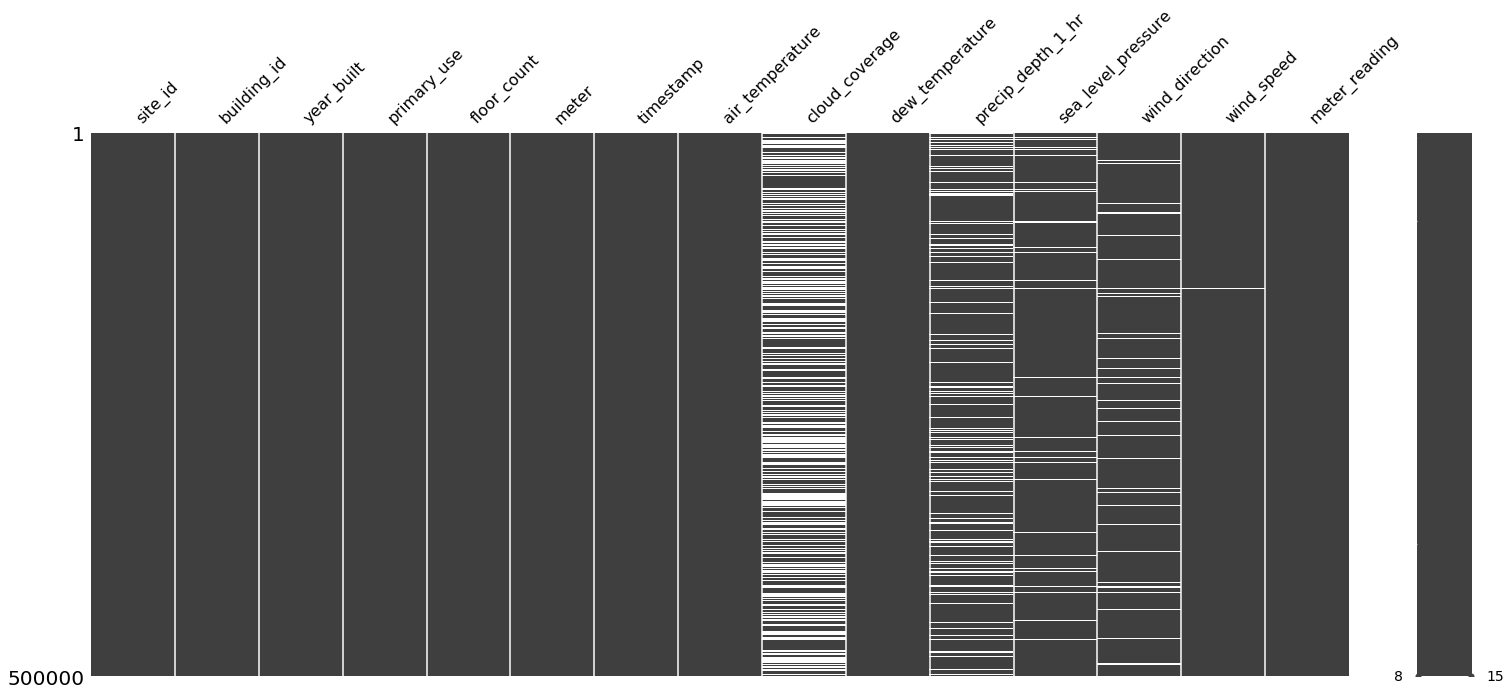

In [18]:
msno.matrix(df_sample)

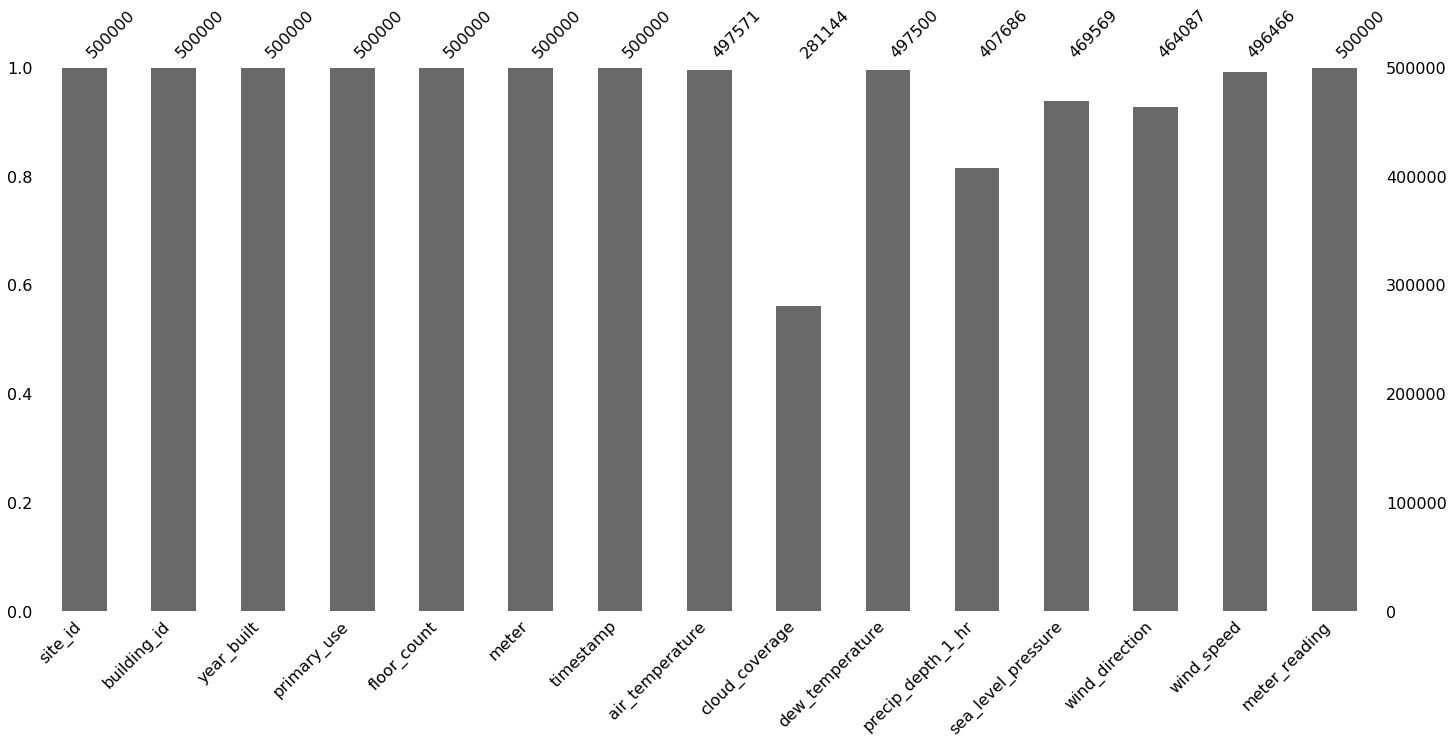

In [19]:
msno.bar(df_sample)

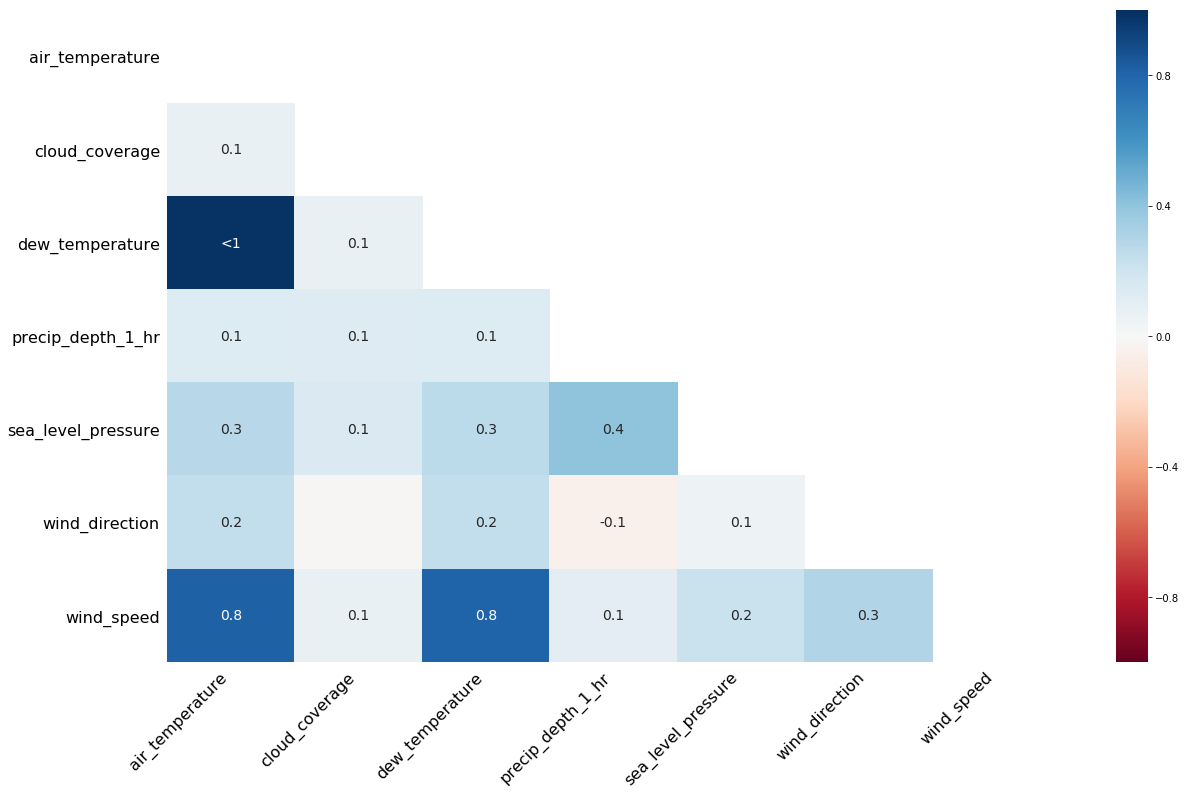

In [20]:
msno.heatmap(df_sample)

There's high correlation in the distribution of `NaN`values between variables `air_temperature`, `dew_temperature` and `wind_speed`. Also there's is a significative correlation in the missing values distribution for `precip_depth_1_hr`and `sea_level_preassure`.

The feature with most of missing values is `cloud_coverage`, and it doesn't seem to be a correlation with any other feature, regarding `NaN` values.

We need a little more information to be able to decide what to do with missing values. A correlation plot between features could be a good advisor. We're only interested in weather variables, as the rest have no missing values.

### Missing values analysis in `weather_train` data set

In [44]:
# Percentage of missing values per column
(weather_train.isna().sum()/weather_train.shape[0]) * 100

site_id                0.000000
timestamp              0.000000
air_temperature        0.039350
cloud_coverage        49.489529
dew_temperature        0.080845
precip_depth_1_hr     35.979052
sea_level_pressure     7.596603
wind_direction         4.484414
wind_speed             0.217496
dtype: float64

In [46]:
# weather group by site
weather_by_site = weather_train.groupby('site_id')

In [52]:
weather_by_site.count()

,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
site_id,,,,,,,,
0,8784,8781,4954,8781,8783,8699,8534,8784
1,8763,8762,1701,8762,0,8711,8760,8763
2,8783,8782,6429,8782,8717,8739,8192,8778
3,8780,8776,5138,8774,8743,8622,8627,8776
4,8783,8783,4553,8781,7466,8710,8678,8783
5,8755,8753,2725,8753,0,0,8460,8752
6,8782,8772,5790,8772,8782,8607,8003,8743
7,8614,8614,0,8591,731,8606,8614,8614
8,8784,8781,4954,8781,8783,8699,8534,8784


In [81]:
weather_by_site.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.000000,6.0,20.000000,NaN,1019.5,0.0,0.000000
1,0,2016-01-01 01:00:00,24.406250,NaN,21.093750,-1.0,1020.0,70.0,1.500000
2,0,2016-01-01 02:00:00,22.796875,2.0,21.093750,0.0,1020.0,0.0,0.000000
3,0,2016-01-01 03:00:00,21.093750,2.0,20.593750,0.0,1020.0,0.0,0.000000
4,0,2016-01-01 04:00:00,20.000000,2.0,20.000000,-1.0,1020.0,250.0,2.599609
8784,1,2016-01-01 00:00:00,3.800781,NaN,2.400391,NaN,1021.0,240.0,3.099609
8785,1,2016-01-01 01:00:00,3.699219,0.0,2.400391,NaN,1021.5,230.0,2.599609
8786,1,2016-01-01 02:00:00,2.599609,0.0,1.900391,NaN,1022.0,0.0,0.000000
8787,1,2016-01-01 03:00:00,2.000000,0.0,1.200195,NaN,1022.5,170.0,1.500000
8788,1,2016-01-01 04:00:00,2.300781,0.0,1.799805,NaN,1022.5,110.0,1.500000


In [61]:
site_list = weather_train['site_id'].unique()

for site in site_list:
    print('SITE {} ============'.format(site))
    print(weather_train.loc[weather_train['site_id'] == site, :].isna().sum()/weather_train.loc[weather_train['site_id'] == site, :].shape[0]*100)
    print('\n')

SITE 0 ============
site_id                0.000000
timestamp              0.000000
air_temperature        0.034153
cloud_coverage        43.602004
dew_temperature        0.034153
precip_depth_1_hr      0.011384
sea_level_pressure     0.967668
wind_direction         2.846084
wind_speed             0.000000
dtype: float64


SITE 1 ============
site_id                 0.000000
timestamp               0.000000
air_temperature         0.011412
cloud_coverage         80.588839
dew_temperature         0.011412
precip_depth_1_hr     100.000000
sea_level_pressure      0.593404
wind_direction          0.034235
wind_speed              0.000000
dtype: float64


SITE 2 ============
site_id                0.000000
timestamp              0.000000
air_temperature        0.011386
cloud_coverage        26.801776
dew_temperature        0.011386
precip_depth_1_hr      0.751452
sea_level_pressure     0.500968
wind_direction         6.728908
wind_speed             0.056928
dtype: float64


SITE 3 =========

In [60]:
weather_train.loc[weather_train['site_id'] == 3, :].shape[0]

8780

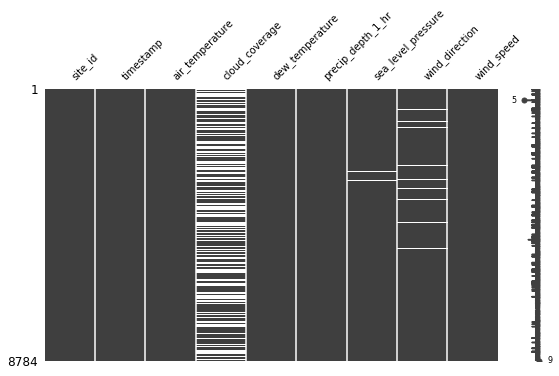

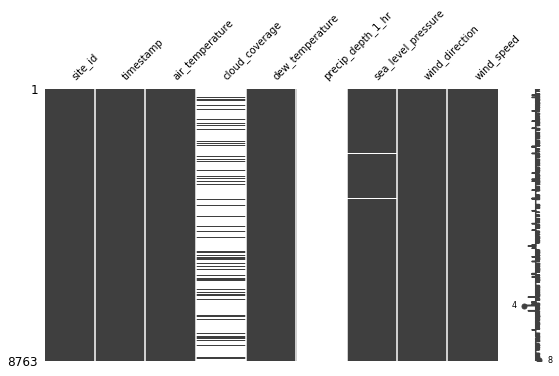

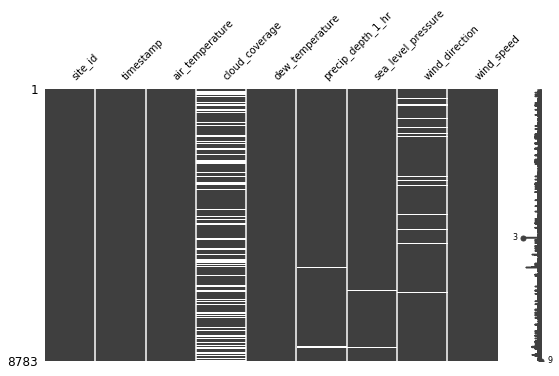

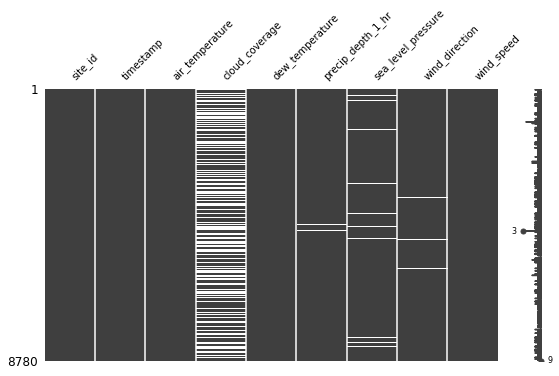

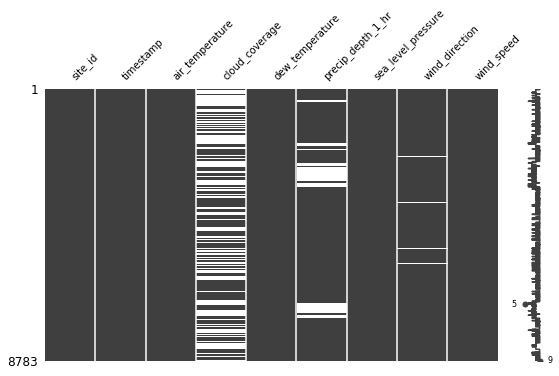

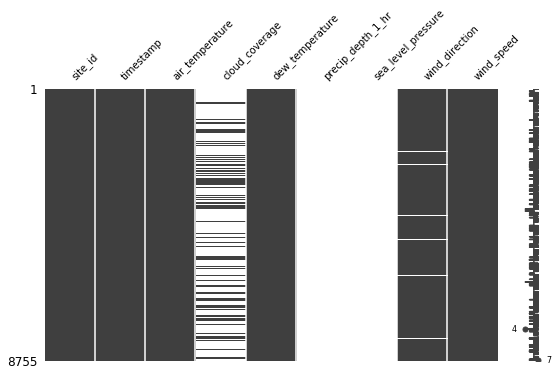

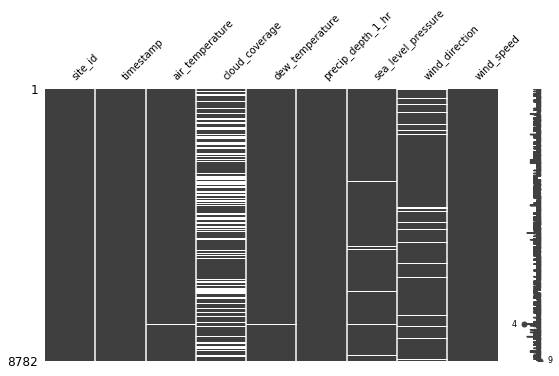

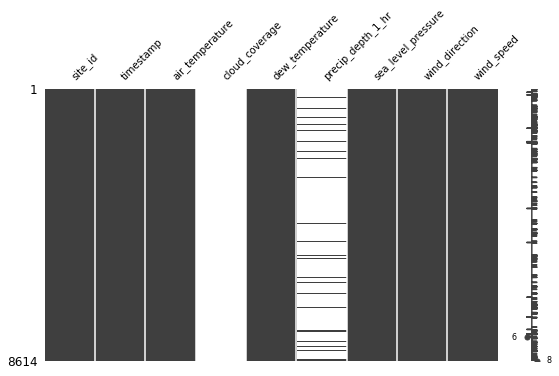

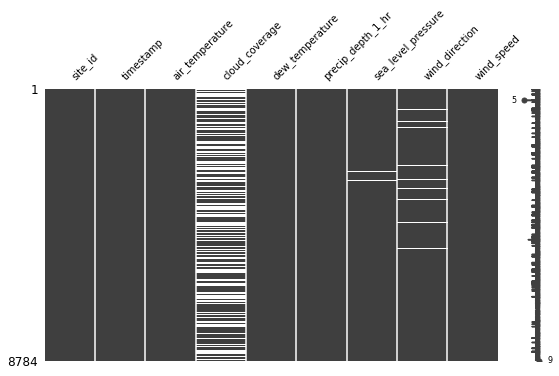

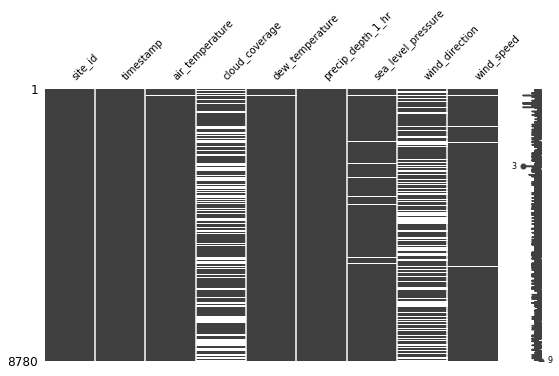

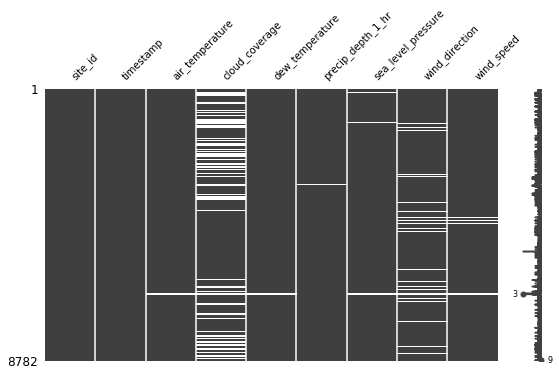

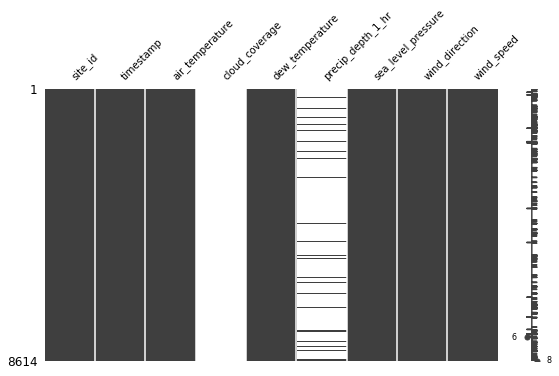

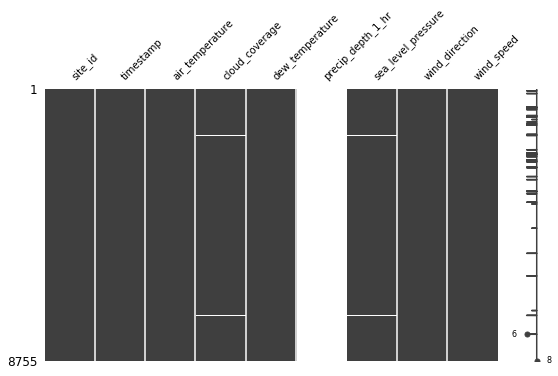

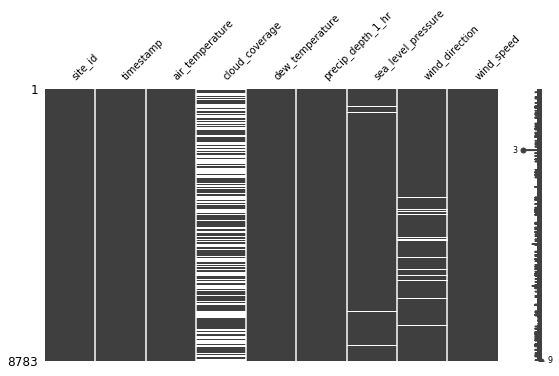

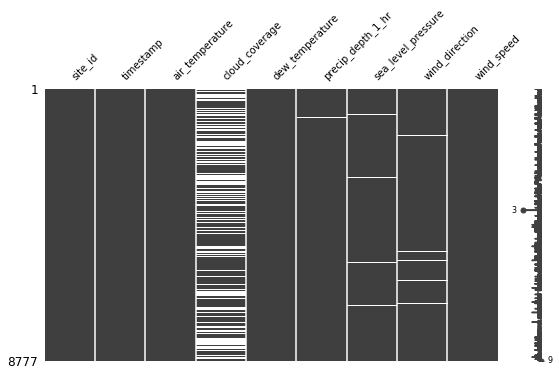

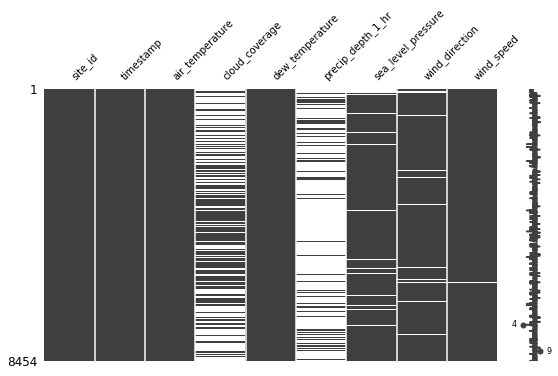

In [104]:
for site in site_list:
    msno.matrix(weather_train.loc[weather_train['site_id'] == site, :], figsize=(9,5), fontsize=10)

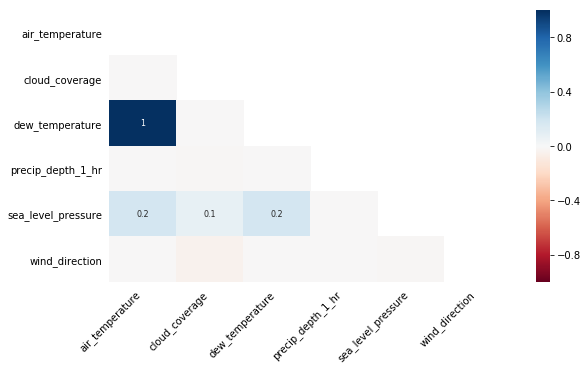

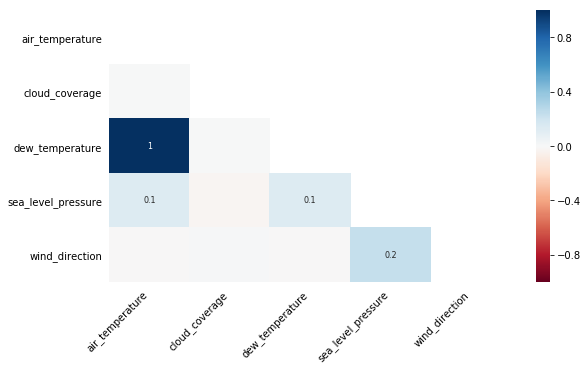

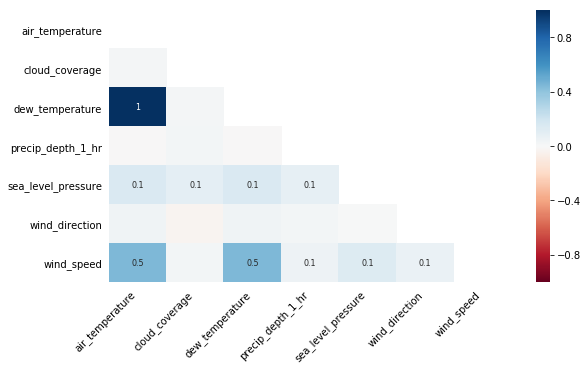

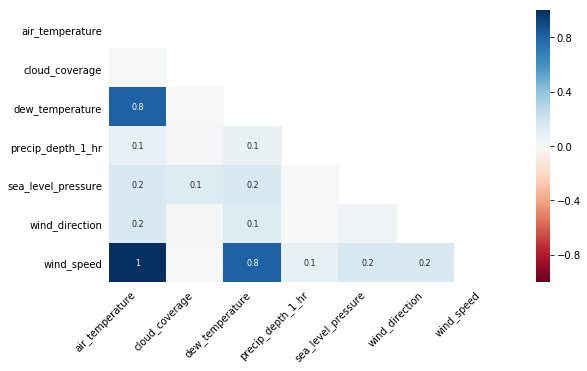

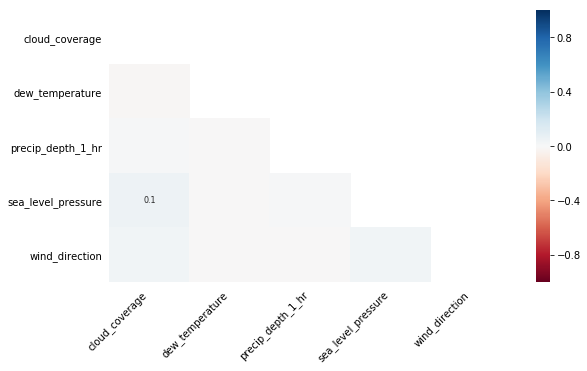

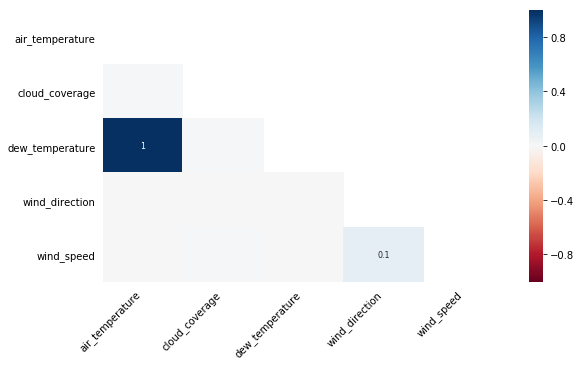

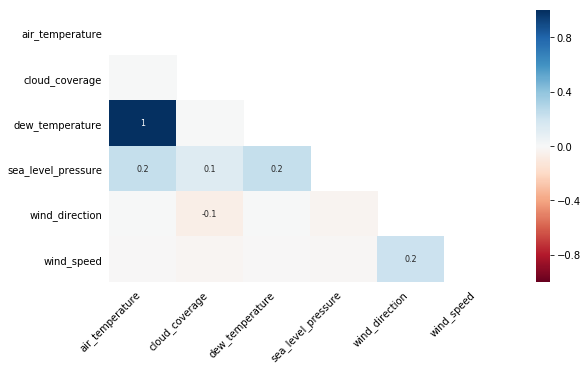

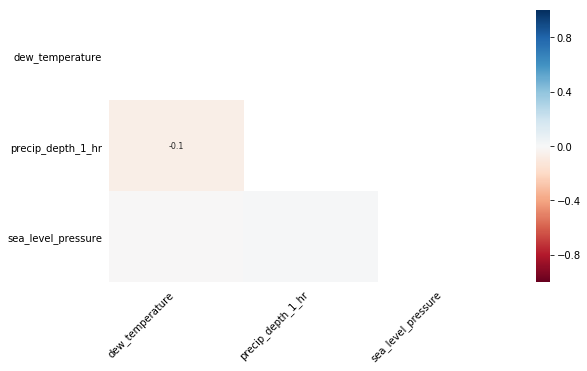

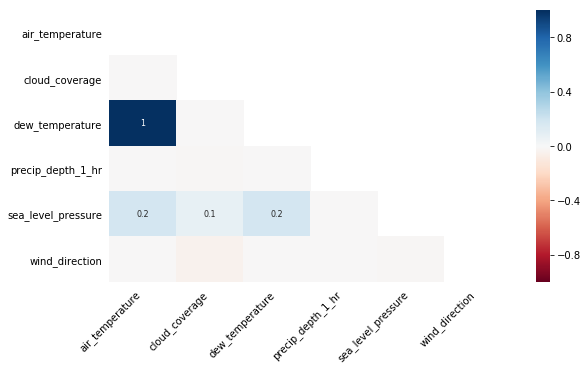

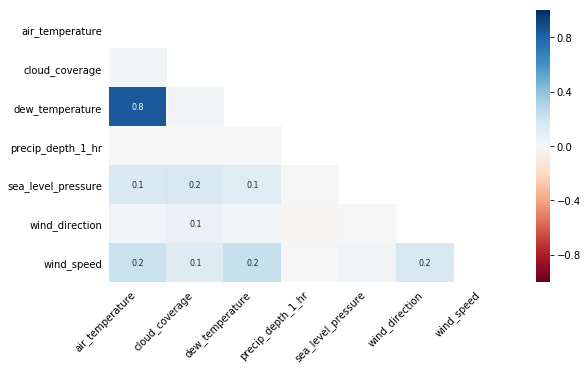

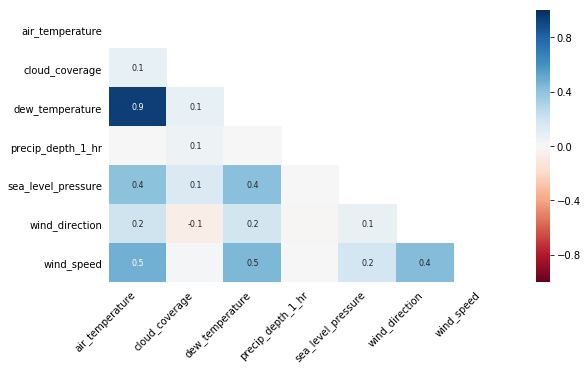

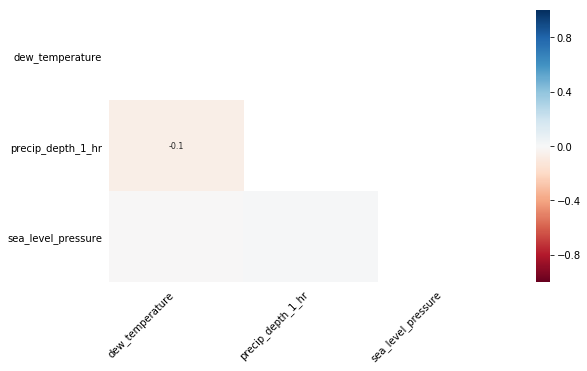

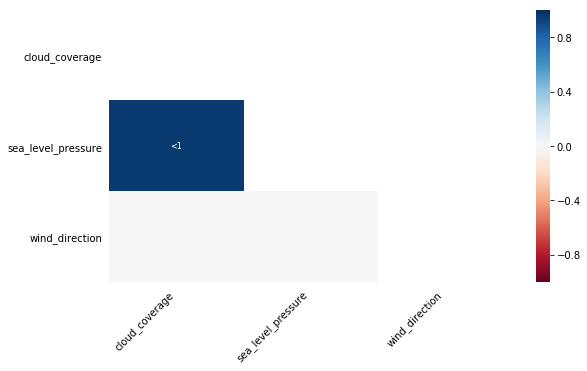

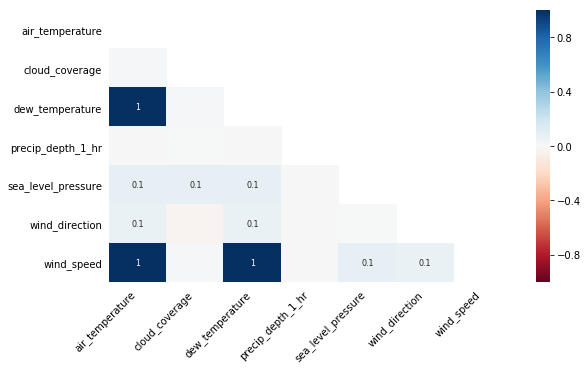

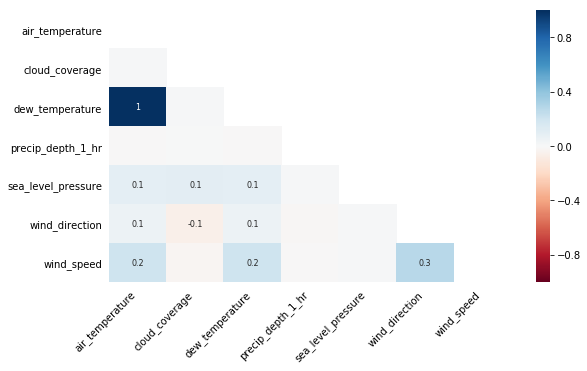

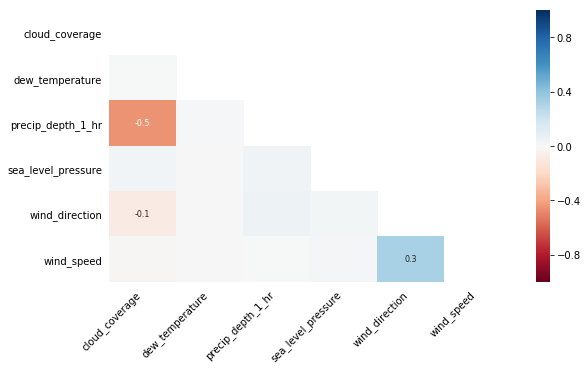

In [105]:
for site in site_list:
    msno.heatmap(weather_train.loc[weather_train['site_id'] == site, :], figsize=(9,5), fontsize=10)

In [114]:
corr = weather_by_site.corr()
corr.style.background_gradient(cmap='coolwarm')

C:\Users\Victor\Anaconda3\lib\site-packages\matplotlib\colors.py:504: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


In [21]:
(df.isna().sum()/df.shape[0])*100

site_id                0.000000
building_id            0.000000
year_built             0.000000
primary_use            0.000000
floor_count           82.652772
meter                  0.000000
timestamp              0.000000
air_temperature        0.478124
cloud_coverage        43.655131
dew_temperature        0.495348
precip_depth_1_hr     18.544739
sea_level_pressure     6.092515
wind_direction         7.167792
wind_speed             0.710701
meter_reading          0.000000
dtype: float64

In [26]:
gc.collect()

2513

In [30]:
df.groupby('building_id').count()

,site_id,year_built,primary_use,floor_count,meter,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
building_id,,,,,,,,,,,,,,
0,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
1,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
2,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
3,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
4,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
5,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
6,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784
7,16051,16051,16051,0,16051,16051,16048,9123,16048,16050,15900,15569,16051,16051
8,8784,8784,8784,0,8784,8784,8781,4954,8781,8783,8699,8534,8784,8784


In [37]:
df_by_building = df.groupby('building_id')
del(df_by_building)

In [43]:
df.loc[df['building_id']==1000,:].head()

,site_id,building_id,year_built,primary_use,floor_count,meter,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed,meter_reading
1379,10,1000,nan,Education,2.0,0,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,43.250099
1380,10,1000,nan,Education,2.0,1,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
1381,10,1000,nan,Education,2.0,3,2016-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,399.864014
3675,10,1000,nan,Education,2.0,0,2016-01-01 01:00:00,-10.601562,0.0,-13.898438,0.0,1037.0,0.0,0.0,44.250000
3676,10,1000,nan,Education,2.0,1,2016-01-01 01:00:00,-10.601562,0.0,-13.898438,0.0,1037.0,0.0,0.0,0.000000


In [44]:
weather_train['air_temperature'].describe()

count    139718.000000
mean               NaN
std           0.000000
min         -28.906250
25%           7.199219
50%          15.000000
75%          22.203125
max          47.187500
Name: air_temperature, dtype: float64

In [50]:
weather_train.loc[weather_train['air_temperature'] > 47, 'site_id']

21649    2
21650    2
21651    2
21652    2
Name: site_id, dtype: int8

In [54]:
weather_train.loc[(weather_train['site_id']==2) & (weather_train['air_temperature'] > 47), :].head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
21649,2,2016-06-19 22:00:00,47.1875,2.0,-0.600098,0.0,1005.0,NaN,2.599609
21650,2,2016-06-19 23:00:00,47.1875,2.0,-2.199219,0.0,1004.0,NaN,2.599609
21651,2,2016-06-20 00:00:00,47.1875,2.0,-1.099609,0.0,1003.5,NaN,2.099609
21652,2,2016-06-20 01:00:00,47.1875,2.0,-1.099609,0.0,1003.0,300.0,5.699219


## Testing methods for filling gaps in `aire_temperature`

Finding observations with missing `aire_temperature` consecutive values.

In [89]:
weather_nans = weather_train.loc[weather_train['air_temperature'].isna()]

In [104]:
weather_nans.groupby('site_id').head()


,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
368,0,2016-01-16 08:00:00,NaN,NaN,NaN,0.0,NaN,180.0,1.500000
369,0,2016-01-16 09:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.500000
370,0,2016-01-16 10:00:00,NaN,2.0,NaN,0.0,NaN,190.0,1.500000
15763,1,2016-10-18 13:00:00,NaN,NaN,NaN,NaN,NaN,290.0,6.199219
22349,2,2016-07-19 02:00:00,NaN,NaN,NaN,86.0,NaN,NaN,NaN
27393,3,2016-02-14 07:00:00,NaN,0.0,NaN,0.0,NaN,NaN,NaN
30910,3,2016-07-09 20:00:00,NaN,NaN,NaN,38.0,NaN,NaN,NaN
30911,3,2016-07-09 21:00:00,NaN,NaN,NaN,8.0,NaN,NaN,NaN
30914,3,2016-07-10 00:00:00,NaN,4.0,NaN,NaN,NaN,NaN,NaN
50108,5,2016-09-17 00:00:00,NaN,NaN,NaN,NaN,NaN,310.0,4.601562
